In [ ]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain.sim_models_new import Toy_intensity_Generator, Toy_intensity_Comparer
import torch
import torch.optim as optim
import torch.nn as nn
import pytorch_warmup as warmup

import paths
from os.path import join

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import simtrain.utils as utils
from tqdm import tqdm
import evotorch
import ray
from functools import partial

os.environ['PYTHONPATH'] = "/home/thahit/github/Recommender_Sim"
#ray.init(ignore_reinit_error=True)


In [ ]:

state_size = SETTINGS.STATE_SIZE
experiment_name = "toy"
#num_negatives = 100
#conditioned=True
#kl_weight=.01

In [ ]:
sfaf

# Data

## Generated Data

In [47]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
gen_model = Toy_intensity_Generator(hyperparameter_dict)

In [48]:
path = join(paths.dat, SETTINGS.filepaths_new["simulate_intensity_model"]
            )
path

'/home/thahit/github/Recommender_Sim/dat/saved_models_polimi/simulate_intensity/gnerator_model.h5'

In [49]:
#torch.save(gen_model.state_dict(), path)
gen_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [50]:
state = torch.zeros((1, state_size))

In [51]:
samples = [gen_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)
samples

array([[2.1],
       [0.4],
       [0.2],
       [0.6],
       [2.2],
       [7.6],
       [0.6],
       [1.1],
       [1.3],
       [0.3],
       [0.1],
       [0.5],
       [0.1],
       [0. ],
       [1.4],
       [3.8],
       [2.7],
       [2. ],
       [2. ],
       [0. ],
       [0.1],
       [0.4],
       [2.3],
       [1.8],
       [0. ],
       [0.1],
       [1.1],
       [2.1],
       [2.3],
       [1.5],
       [1.3],
       [1.6],
       [0.5],
       [1.1],
       [0.4],
       [1.1],
       [1.2],
       [0.1],
       [1.8],
       [0.8],
       [0.4],
       [0.9],
       [1.2],
       [0.5],
       [0.7],
       [0.1],
       [1.6],
       [2.2],
       [1.5],
       [0.4],
       [3.4],
       [0.3],
       [3.3],
       [2.3],
       [0.4],
       [1.2],
       [4. ],
       [2.5],
       [0.5],
       [0.6],
       [0.8],
       [0.4],
       [3.3],
       [3.9],
       [0.7],
       [0.6],
       [0.1],
       [0.7],
       [1.9],
       [0.4],
       [1.1],
      

feed in true values for fake models, 


/tmp/ipykernel_14494/2138906594.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)


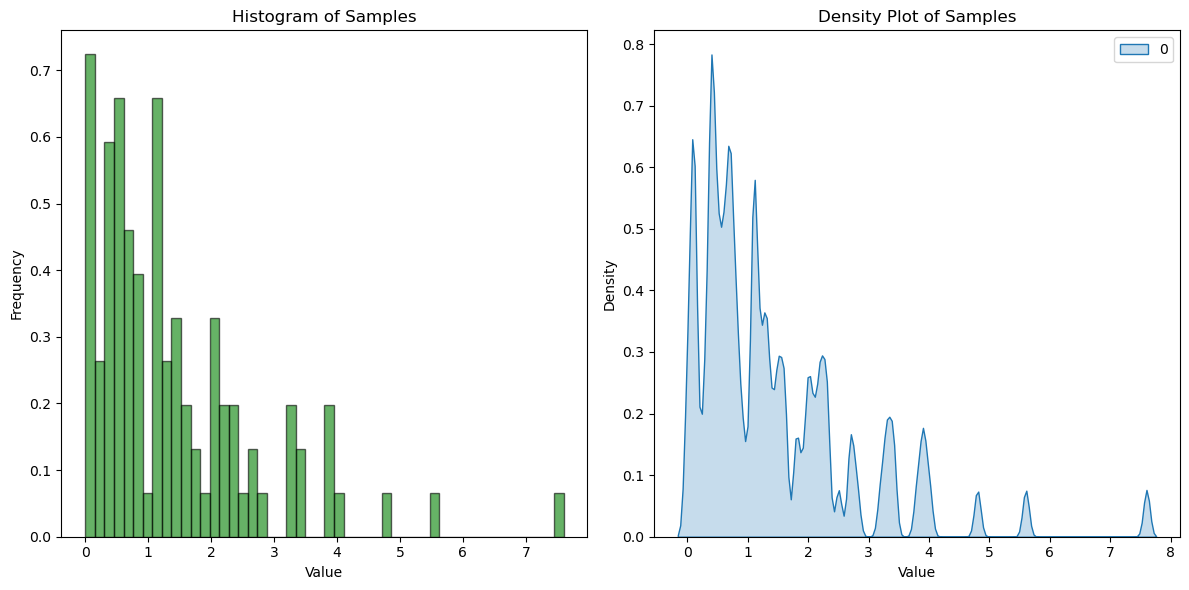

In [52]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [56]:
sample_path = gen_model.sample_path(num_samples=5)
sample_path =torch.tensor(sample_path)
sample_path

tensor([[2.7000],
        [3.4000],
        [4.9000],
        [5.4000],
        [6.5000]])

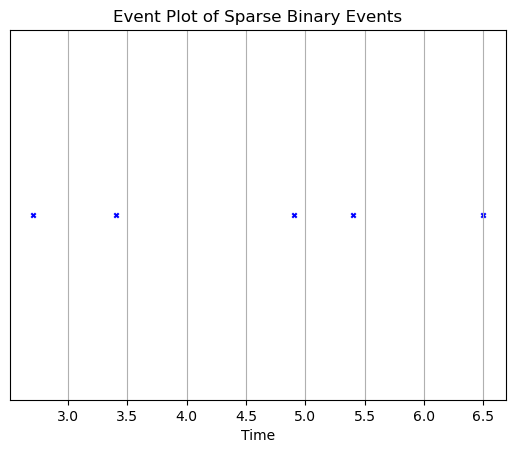

In [57]:
#plt.eventplot(sample_path, orientation='vertical', colors='r')
plt.scatter(sample_path, [1] * len(sample_path), color='blue', label='Time Series 1', s=10, marker='x')

plt.yticks([])
plt.xlabel('Time')
plt.title('Event Plot of Sparse Binary Events')
plt.grid(True)
plt.show()


In [ ]:
asdafa

## Real data

In [ ]:
checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
                             "testing", "data.h5"))
list_of_dicts = checkpoint['data']
chosen_sample = list_of_dicts[4]["timestamps"]
sample_path =torch.tensor(chosen_sample)
sample_path

In [ ]:
#plt.eventplot(sample_path, orientation='vertical', colors='r')
plt.scatter(sample_path, [1] * len(sample_path), color='blue', label='Time Series 1', s=10, marker='x')

plt.yticks([])
plt.xlabel('Time')
plt.title('Event Plot of Sparse Binary Events')
plt.grid(True)
plt.show()


# Model

## Train Gradient Descent
Not working

### base

In [ ]:
def train_single(model, path, scoring_func,optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        last_t = 0
        state = torch.zeros((1, state_size))
        loss = 0.
        #results = []
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                current_pred.append(last_t + model.sample_one(state))
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += torch.log(scoring_func(current_pred, timestep))
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
        print("loss: ", loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        #for name, param in model.named_parameters():
        #    print(f"Parameter Name: {name}")
        #    print(f"Parameter Value: {param}")
        #    print(f"Gradients: {param.grad}")
        #    print(f"Parameter Shape: {param.shape}")
        #    print(f"Requires Gradient: {param.requires_grad}")
        #    print("-" * 40)
        #return
        optimizer.zero_grad()


In [ ]:
# parameter dicts
width= 16
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [ ]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [ ]:
sample_path = torch.as_tensor(sample_path)
optimizer = optim.AdamW(train_model.parameters(), lr=0.1,
                        weight_decay=1e-7)


In [ ]:
#train_single(train_model, sample_path, scoring_func=utils.energy_score_loss,
#            optimizer=optimizer, num_epochs=30, num_tries=10)

### function approximation



In [35]:
from simtrain.sim_models_new import all_in_one_model

width=16
user_state_dict = {"model_hyp": {"layer_width": [width for _ in range(3)]}}
time_dict = {"model_hyp": {"layer_width": [width for _ in range(3)]}
            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "time_model": time_dict, 
                           "state_model": user_state_dict}
train_model = all_in_one_model(hyperparameter_dict, timecheat=timecheat)

In [36]:
from simtrain.train import train_single_function_approx

In [37]:
steps_per_epoch = 1

num_epochs = 1500
warmup_period = steps_per_epoch * 10
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = num_steps + 1
user_lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(train_model.parameters(), lr=user_lr,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-7)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [38]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            state_size=state_size, warmup_scheduler=warmup_scheduler, lr_scheduler=lr_scheduler,
            optimizer=optimizer, num_epochs=num_epochs, num_tries=30, timecheat=timecheat, loss_print_interval=num_epochs//20,
            warmup_period=warmup_period)


  0%|          | 6/1500 [00:00<00:54, 27.49it/s]

epch: 0 loss_sum: 78.3884


  5%|▌         | 80/1500 [00:02<00:44, 31.73it/s]

epch: 75 loss_sum: 71.2091


 10%|█         | 156/1500 [00:04<00:39, 33.87it/s]

epch: 150 loss_sum: 26.6161


 15%|█▌        | 228/1500 [00:06<00:39, 31.81it/s]

epch: 225 loss_sum: 16.2955


 20%|██        | 303/1500 [00:09<00:40, 29.76it/s]

epch: 300 loss_sum: 14.8770


 25%|██▌       | 379/1500 [00:11<00:32, 34.75it/s]

epch: 375 loss_sum: 11.4655


 30%|███       | 455/1500 [00:13<00:30, 34.73it/s]

epch: 450 loss_sum: 9.2112


 35%|███▌      | 531/1500 [00:16<00:28, 33.98it/s]

epch: 525 loss_sum: 7.2688


 40%|████      | 603/1500 [00:18<00:29, 30.92it/s]

epch: 600 loss_sum: 9.8576


 45%|████▌     | 679/1500 [00:20<00:22, 36.72it/s]

epch: 675 loss_sum: 11.0366


 50%|█████     | 755/1500 [00:22<00:22, 33.13it/s]

epch: 750 loss_sum: 6.3506


 55%|█████▌    | 831/1500 [00:24<00:18, 35.55it/s]

epch: 825 loss_sum: 6.7794


 60%|██████    | 907/1500 [00:27<00:16, 36.61it/s]

epch: 900 loss_sum: 4.5808


 65%|██████▌   | 979/1500 [00:29<00:14, 35.28it/s]

epch: 975 loss_sum: 7.7988


 70%|███████   | 1055/1500 [00:31<00:11, 37.13it/s]

epch: 1050 loss_sum: 5.0393


 75%|███████▌  | 1129/1500 [00:33<00:11, 32.77it/s]

epch: 1125 loss_sum: 5.3564


 80%|████████  | 1205/1500 [00:35<00:08, 33.83it/s]

epch: 1200 loss_sum: 4.6753


 85%|████████▌ | 1281/1500 [00:38<00:06, 32.70it/s]

epch: 1275 loss_sum: 4.9589


 90%|█████████ | 1353/1500 [00:40<00:05, 28.98it/s]

epch: 1350 loss_sum: 4.6316


 95%|█████████▌| 1428/1500 [00:44<00:04, 17.33it/s]

epch: 1425 loss_sum: 4.1313


100%|██████████| 1500/1500 [00:47<00:00, 31.47it/s]

epch: 1499 loss_sum: 4.3317


In [ ]:
sdfsdf

In [ ]:
optimizer = optim.AdamW(train_model.parameters(), lr=0.0001,
                        weight_decay=1e-7)

In [ ]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=3000,timecheat=timecheat, num_tries=20, 
            loss_print_interval=20, state_size=state_size,)

In [ ]:
adsfasdf

### Predict intensities

In [ ]:
train_sorted = False
batchsize = 1

In [ ]:
width=64
intensity = {"model_hyp": {"layer_width": [width for _ in range(3)]}}
state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)]},
            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "state_model": state_dict, 
                           "intensity_model": intensity,
                           "time_embedding_size" :32, "max_freq": 20,
                           }
model = Toy_intensity_Comparer(hyperparameter_dict)
print(model)


In [ ]:
# create dataset

import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from simtrain.Dataset import TimestepFrequencyDataset

# Example usage
dataset = TimestepFrequencyDataset(sample_path, num_random_points=150)

# Accessing items from the dataset
for i in range(min(len(dataset), 20)):
    sample = dataset[i]
    print(f"Timestep: {sample['timestep'].item():.4f}, Frequency: {sample['frequency'].item()}")

dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=not train_sorted
                        )

In [ ]:
steps_per_epoch = len(dataset) // batchsize  
if len(dataset) % batchsize  != 0:
    steps_per_epoch+=1
num_epochs = 200
warmup_period = steps_per_epoch
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = num_steps + 1
user_lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=user_lr,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=5e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


In [ ]:
from simtrain.train import train_density

def train_density_sorted():
    pass

def print_res(model, dataloader, criterion,state_size):
    for batch in dataloader:
        timesteps = batch['timestep'].unsqueeze(1)  # Add batch dimension
        frequencies = batch['frequency']
        state = torch.zeros((len(timesteps), state_size))
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(state, timesteps)

        loss = criterion(outputs, frequencies)  # Remove extra dimension from output
        print(f"loss: {loss} \tfrequencies: {frequencies} \t predicted: {outputs}, \ttime: {timesteps}")
        loss.backward()

        #for name, param in model.named_parameters():
        #    print(f"Parameter Name: {name}")
        #    print(f"Gradients: {param.grad}")


In [ ]:
from simtrain.utils import weighted_mse_loss

In [ ]:
train_density(model, dataloader, criterion=weighted_mse_loss, state_size=state_size,
                optimizer=optimizer, num_epochs=num_epochs, warmup_scheduler=warmup_scheduler,
                loss_print_interval=50, warmup_period=warmup_period, lr_scheduler=lr_scheduler)

In [ ]:
#dataloader = DataLoader(dataset, batch_size=1, shuffle=not train_sorted) 

In [ ]:
print(len(dataset))

In [ ]:
print_res(model, dataloader, weighted_mse_loss, state_size=state_size,)

In [ ]:
x_range = np.linspace(-1, 71, 200)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
state = torch.zeros((len(x_range), state_size))
model.eval()
with torch.no_grad():
    predictions = model(state, x_range_tensor).numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sfdsd

In [ ]:
x_range = np.linspace(-1, 70, 200)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
state = torch.zeros((len(x_range), state_size))
model.eval()
with torch.no_grad():
    predictions = model(state, x_range_tensor).numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height =sample['frequency'].item()+.1
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x_range = np.linspace(-1, 70, 200)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
state = torch.zeros((len(x_range), state_size))
model.eval()
with torch.no_grad():
    predictions = model(state, x_range_tensor).numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height =sample['frequency'].item()+.1
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
x_range = np.linspace(-1, 70, 200)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
state = torch.zeros((len(x_range), state_size))
model.eval()
with torch.no_grad():
    predictions = model(state, x_range_tensor).numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height =sample['frequency'].item()+.1
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

## Train via Evolution

In [ ]:
from evotorch.algorithms import PGPE, CMAES
from evotorch.logging import PandasLogger
from functools import partial


In [ ]:
# parameter dicts
width= 64
user_state_dict = {"model_hyp": {"layer_width": [width,width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width,width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [ ]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [ ]:

def eval_single(model, path, scoring_func, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    loss = 0.
    #results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
    
    return loss


eval_single_partial = partial(eval_single, path=sample_path, scoring_func=utils.energy_score_loss,
                              num_tries=30)

In [ ]:
eval_single_partial(train_model)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Single_path_problem = evotorch.neuroevolution.NEProblem(
    objective_sense="min",
    network= train_model,
    #network=Toy_intensity_Generator,
    #network_args = {"hyperparameter_dict": hyperparameter_dict},
    network_eval_func=eval_single_partial,
    device=device,
    num_actors = 20,
)

In [ ]:


searcher = PGPE(
    Single_path_problem,
    popsize=40,
    radius_init=5.,
    center_learning_rate=0.2,
    stdev_learning_rate=0.05,
)
'''
searcher = CMAES(
    Single_path_problem,
    popsize=20,  
    stdev_init= 2.
)'''

logger = PandasLogger(searcher)



In [ ]:
num_iterations = 20
for _ in tqdm(range(num_iterations), desc="Running PGPE"):
    searcher.step()

1 epoch = 50(population) * 20(samples for expectation) * 1(number of paths) * 10'000(integration/for loop steps, worst case) * (2+1) (neural network calls) *10(number of events)= 300m NN calls per epoch

for much worse approximation and still way too much compute:<br>
1 epoch = 20(population) * 20(samples for expectation) * 1(number of paths) * 100(integration/for loop steps, worst case) * (2+1) (neural network calls) *10(number of events)= 1.2m NN calls per epoch


lstm/rnn  feed last hidden state + actual state to predict probability increase,  stop at  threshhold chosen by uniform 


neural network(time? + state)  -> time + state

noise for time but not state

normalizing flows?

In [ ]:
logger.to_dataframe().mean_eval.plot()# test datapoint CMA ES

In [ ]:
asdcas

In [ ]:
trained_network = Single_path_problem.parameterize_net(searcher.status["center"])


In [ ]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(trained_network.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))
#trained_network = train_model

# Visualize

In [39]:
trained_network = train_model

In [40]:

def simulate_single_forced(model, path, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            print(f"var(forced): {torch.var(current_pred)}")
            #loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
    
    return results


def simulate_single(model, num_events, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for i in range(num_events):
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            print(f"var: {torch.var(current_pred)}")
            selected = torch.mean(current_pred)
            results.append(selected)
            delta = selected-last_t
            last_t = selected
            state = model.evolve_state(state, delta)
    
    return results

#_________________________________function approx integral_sampling_______________________
def simulate_single_forced_function_approx(model, path, 
                                           timecheat=False, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, last_t)
                else:
                    next_time=model.get_time(state)
                #print(f"next_time: {next_time}, next_state: {next_state}")
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            last_t = timestep
            state = model.get_new_state(state, torch.tensor([[timestep]]))
    
    return results

def simulate_single_function_approx(model, num_events=10, timecheat=False, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for _ in range(num_events):
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, last_t)
                else:
                    next_time=model.get_time(state)
                
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            selected = torch.mean(current_pred)
            results.append(selected)
            last_t = selected
            state = model.get_new_state(state, torch.tensor([[selected]]))
    
    return results



In [41]:
# simpler nn
simulate_single_partial_forced_function_approx = partial(
    simulate_single_forced_function_approx, path=sample_path,
                              num_tries=1, timecheat=timecheat)
simulate_single_partial_function_approx =partial(
    simulate_single_function_approx, num_events =len(sample_path),
                              num_tries=1, timecheat=timecheat)

In [ ]:
# integrals
simulate_single_partial_forced = partial(simulate_single_forced, path=sample_path, 
                              num_tries=2)

simulate_single_partial = partial(simulate_single, num_events=12,
                              num_tries=2)


In [42]:
# intensity
example_out_forced = simulate_single_partial_forced(trained_network)
example_out = simulate_single_partial(trained_network)

NameError: name 'simulate_single_partial_forced' is not defined

In [45]:
#mlp
example_out_forced = simulate_single_partial_forced_function_approx(trained_network)
example_out = simulate_single_partial_function_approx(trained_network)

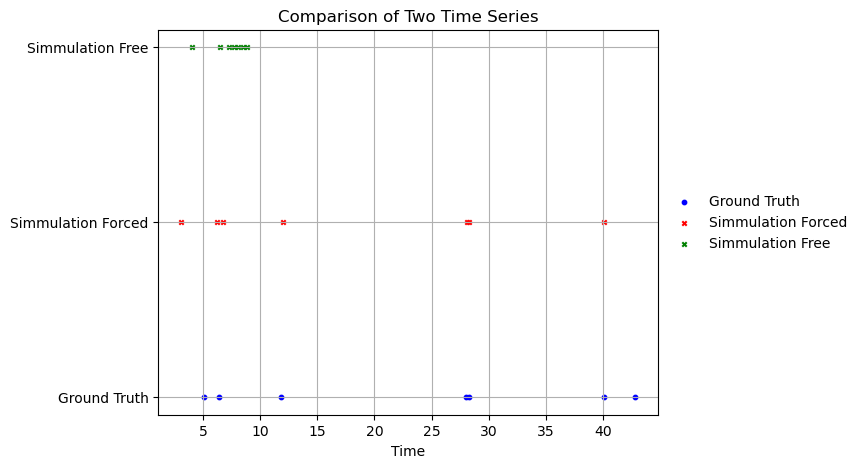

In [46]:

import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
asdfasf

In [ ]:
# 3 layers
import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
SCA

In [ ]:

import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
scsdc

In [ ]:
state = torch.zeros((1, state_size))
samples = [train_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)

In [ ]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()
